In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import zipfile
from tqdm import tqdm    #biblioteca que cria barras de progresso da função
from pathlib import Path
from rasterio.enums import Resampling

In [2]:
#Acessando as imagens
# Lista dos nomes das suas pastas de data

base_path = os.path.join(Path.home(), "compartilhado/Natacha/arquivos/Arquivos/") #coloquen aqui o seu diretório das imagens do Copernicus

pastas_de_data = [
    "28_08_2018",
    "22_09_2018", # <--- Coloque aqui os nomes corretos das suas pastas
    "21_11_2018",
    "06_12_2018",
    "09_02_2019",
    "01_03_2019",
    "30_04_2019"
]


# Lista do diretório completo dos arquivos do Sentinel e iteração de cada arquivo "data" 

lista_diretorios_bandas = [os.path.join(base_path, data) for data in pastas_de_data]
print("Caminhos que serão processados:")
for caminho in lista_diretorios_bandas:
    print(caminho)

class_labels = {
    1: 'Vegetação Nativa', 2: 'Água Permanente', 3: 'Áreas Construídas/Impermeáveis', 4: 'Solo Exposto e Vegetação Rala', 5: 'Agricultura Sazonal'
}

Caminhos que serão processados:
/home/jovyan/compartilhado/Natacha/arquivos/Arquivos/28_08_2018
/home/jovyan/compartilhado/Natacha/arquivos/Arquivos/22_09_2018
/home/jovyan/compartilhado/Natacha/arquivos/Arquivos/21_11_2018
/home/jovyan/compartilhado/Natacha/arquivos/Arquivos/06_12_2018
/home/jovyan/compartilhado/Natacha/arquivos/Arquivos/09_02_2019
/home/jovyan/compartilhado/Natacha/arquivos/Arquivos/01_03_2019
/home/jovyan/compartilhado/Natacha/arquivos/Arquivos/30_04_2019


In [3]:
# Encontro o arquivo com um suposto prefixo no diretório (relacionado às bandas do Sentinel)
def find_band_file(band_dir, band_prefix):
    for file in os.listdir(band_dir):
        if band_prefix in file and file.endswith('.jp2'):
            return os.path.join(band_dir, file)    #junto um endereço de diretório ao outro
    raise FileNotFoundError(f"Arquivo da banda {band_prefix} não encontrado em {band_dir}")

def calculate_indices(band_paths):
    """
    Calcula os índices NDVI, EVI, NDWI, SAVI e NDBI a partir dos caminhos das bandas.
    Realiza a reamostragem da banda SWIR (20m) para 10m.
    """
    
    with rasterio.open(band_paths['B2']) as b2:
        blue = b2.read(1).astype('float32') / 10000
        profile = b2.profile  
        shape_10m = b2.shape   

    with rasterio.open(band_paths['B3']) as b3:
        green = b3.read(1).astype('float32') / 10000
    with rasterio.open(band_paths['B4']) as b4:
        red = b4.read(1).astype('float32') / 10000
    with rasterio.open(band_paths['B8']) as b8:
        nir = b8.read(1).astype('float32') / 10000

   
    with rasterio.open(band_paths['B11']) as b11:
        swir = b11.read(1,
                        out_shape=shape_10m,
                        resampling=Resampling.bilinear
                       ).astype('float32') / 10000

    # Evita erros de divisão por zero
    np.seterr(divide='ignore', invalid='ignore')

  
    ndvi = (nir - red) / (nir + red)
    evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
    evi = np.clip(evi, -1, 1)
    ndwi = (green - nir) / (green + nir)

    
    L = 0.5 # Fator de ajuste do solo
    savi = ((nir - red) / (nir + red + L)) * (1 + L)
    ndbi = (swir - nir) / (swir + nir)

    
    return ndvi, evi, ndwi, savi, ndbi, profile

In [4]:
# Função Temporal
def criar_features_temporais(lista_dirs):
    """
    Processa uma série de imagens Sentinel-2, calcula índices e extrai features
    estatísticas temporais para cada pixel.
    """
    # Crio pilhas das imagens ( matriz 2D --> array 3D de tempo, altura e largura) em uma série temporal para análise da variação
    pilha_ndvi, pilha_evi, pilha_ndwi, pilha_savi, pilha_ndbi = [], [], [], [], []
    profile = None       #contém as informações de cada pixel --> altura, largura, crs, etc...

    print(f"Processando {len(lista_dirs)} imagens para criar a série temporal...")
    for band_dir in tqdm(lista_dirs, desc="Calculando Índices"):    #desc cria o título da barra de progresso
        band_paths = {
            'B2': find_band_file(band_dir, '_B02_10m'),
            'B3': find_band_file(band_dir, '_B03_10m'),
            'B4': find_band_file(band_dir, '_B04_10m'),
            'B8': find_band_file(band_dir, '_B08_10m'),
            'B11': find_band_file(band_dir, '_B11_20m')
        }
       
        ndvi, evi, ndwi, savi, ndbi, current_profile = calculate_indices(band_paths)
        if profile is None:
            profile = current_profile

        pilha_ndvi.append(ndvi)
        pilha_evi.append(evi)
        pilha_ndwi.append(ndwi)
        pilha_savi.append(savi)
        pilha_ndbi.append(ndbi)

    print("\nEmpilhando imagens e calculando estatísticas temporais...")
    stack_ndvi = np.ma.masked_invalid(np.array(pilha_ndvi))       # tiro os valores mascarados com NaN, Inf, etc...
    stack_evi = np.ma.masked_invalid(np.array(pilha_evi))
    stack_ndwi = np.ma.masked_invalid(np.array(pilha_ndwi))
    stack_savi = np.ma.masked_invalid(np.array(pilha_savi))
    stack_ndbi = np.ma.masked_invalid(np.array(pilha_ndbi))

    features_dict = {
        'ndvi_media': np.ma.mean(stack_ndvi, axis=0).filled(0),
        'ndvi_max': np.ma.max(stack_ndvi, axis=0).filled(0),
        'ndvi_min': np.ma.min(stack_ndvi, axis=0).filled(0),
        'ndvi_std': np.ma.std(stack_ndvi, axis=0).filled(0),
        'evi_media': np.ma.mean(stack_evi, axis=0).filled(0),
        'evi_max': np.ma.max(stack_evi, axis=0).filled(0),
        'evi_min': np.ma.min(stack_evi, axis=0).filled(0),
        'evi_std': np.ma.std(stack_evi, axis=0).filled(0),
        'ndwi_media': np.ma.mean(stack_ndwi, axis=0).filled(0),
        'ndwi_max': np.ma.max(stack_ndwi, axis=0).filled(0),
        'ndwi_min': np.ma.min(stack_ndwi, axis=0).filled(0),
        'ndwi_std': np.ma.std(stack_ndwi, axis=0).filled(0),
        # ADICIONADO: Features temporais para SAVI
        'savi_media': np.ma.mean(stack_savi, axis=0).filled(0),
        'savi_max': np.ma.max(stack_savi, axis=0).filled(0),
        'savi_min': np.ma.min(stack_savi, axis=0).filled(0),
        'savi_std': np.ma.std(stack_savi, axis=0).filled(0),
        # ADICIONADO: Features temporais para NDBI
        'ndbi_media': np.ma.mean(stack_ndbi, axis=0).filled(0),
        'ndbi_max': np.ma.max(stack_ndbi, axis=0).filled(0),
        'ndbi_min': np.ma.min(stack_ndbi, axis=0).filled(0),
        'ndbi_std': np.ma.std(stack_ndbi, axis=0).filled(0),
    }

    #crio um novo dicionário com os dados de features_dict
    print("Preparando dados para o modelo...")
    X_image_temporal = pd.DataFrame({
        key: value.flatten() for key, value in features_dict.items()    
    })

    print(f"Features temporais criadas com sucesso. Shape: {X_image_temporal.shape}")
    return X_image_temporal, profile


In [5]:
def generate_temporal_samples(n_per_class=200):     #testar com 500, 1000
    np.random.seed(42)
    samples = []
    def sample_range(low, high, size):
        return np.random.uniform(low, high, size)

    # 1 - Vegetação Nativa (Matas nativas, florestas, áreas de preservação que não sofrem alteração ao longo do ano)
    # CHAVE: NDVI/EVI/SAVI com média alta e desvio padrão BAIXO.
    for _ in range(n_per_class):
        samples.append({
            'ndvi_media': sample_range(0.65, 0.85, 1)[0], 'ndvi_std': sample_range(0.01, 0.08, 1)[0],
            'evi_media': sample_range(0.55, 0.75, 1)[0], 'evi_std': sample_range(0.01, 0.08, 1)[0],
            'ndwi_media': sample_range(0.1, 0.3, 1)[0], 'ndwi_std': sample_range(0.05, 0.15, 1)[0],
            'savi_media': sample_range(0.65, 0.85, 1)[0], 'savi_std': sample_range(0.01, 0.08, 1)[0], # SAVI similar a NDVI
            'ndbi_media': sample_range(-0.4, -0.2, 1)[0], 'ndbi_std': sample_range(0.01, 0.08, 1)[0], # NDBI negativo
            'label': 1
        })

    # 2 - Água Permanente (Corpos d'água que são estáveis ao longo do tempo)
    # CHAVE: NDWI com média alta e desvio padrão BAIXO
    for _ in range(n_per_class):
        samples.append({
            'ndvi_media': sample_range(-0.5, -0.2, 1)[0], 'ndvi_std': sample_range(0.01, 0.1, 1)[0],
            'evi_media': sample_range(-0.4, -0.1, 1)[0], 'evi_std': sample_range(0.01, 0.1, 1)[0],
            'ndwi_media': sample_range(0.4, 0.8, 1)[0], 'ndwi_std': sample_range(0.01, 0.1, 1)[0],
            'savi_media': sample_range(-0.5, -0.2, 1)[0], 'savi_std': sample_range(0.01, 0.1, 1)[0],
            'ndbi_media': sample_range(-0.6, -0.3, 1)[0], 'ndbi_std': sample_range(0.01, 0.1, 1)[0],
            'label': 2
        })

    # 3 - Áreas Construídas / Impermeáveis (Áreas urbanas, estradas, construções)
    for _ in range(n_per_class):
        samples.append({
            'ndvi_media': sample_range(0.05, 0.2, 1)[0], 'ndvi_std': sample_range(0.01, 0.05, 1)[0],
            'evi_media': sample_range(0.05, 0.15, 1)[0], 'evi_std': sample_range(0.01, 0.05, 1)[0],
            'ndwi_media': sample_range(-0.2, 0.0, 1)[0], 'ndwi_std': sample_range(0.01, 0.08, 1)[0],
            'savi_media': sample_range(0.05, 0.2, 1)[0], 'savi_std': sample_range(0.01, 0.05, 1)[0],
            'ndbi_media': sample_range(0.1, 0.4, 1)[0], 'ndbi_std': sample_range(0.01, 0.08, 1)[0], # NDBI é a chave aqui!
            'label': 3
        })

    # 4 - Solo Exposto e Vegetação Rala ( Áreas que permanecem com pouca ou nenhuma cobertura vegetal durante todo o período de análise)
    # CHAVE: NDVI/EVI/SAVI com média baixa e desvio padrão BAIXO.
    for _ in range(n_per_class):
        samples.append({
            'ndvi_media': sample_range(0.1, 0.25, 1)[0], 'ndvi_std': sample_range(0.01, 0.08, 1)[0],
            'evi_media': sample_range(0.1, 0.2, 1)[0], 'evi_std': sample_range(0.01, 0.08, 1)[0],
            'ndwi_media': sample_range(-0.1, 0.1, 1)[0], 'ndwi_std': sample_range(0.01, 0.1, 1)[0],
            'savi_media': sample_range(0.15, 0.3, 1)[0], 'savi_std': sample_range(0.01, 0.08, 1)[0], # SAVI um pouco > NDVI
            'ndbi_media': sample_range(-0.1, 0.15, 1)[0], 'ndbi_std': sample_range(0.01, 0.08, 1)[0],
            'label': 4
        })

    # 5 - Vegetação Sazonal (Áreas que alternam entre solo exposto (preparo/pós-colheita) e vegetação densa - pico da cultura)
    # CHAVE: Desvio padrão MUITO ALTO para NDVI/EVI/SAVI, indicando o ciclo de crescimento

    for _ in range(n_per_class):
        samples.append({
            'ndvi_media': sample_range(0.3, 0.6, 1)[0], 'ndvi_std': sample_range(0.25, 0.45, 1)[0],
            'evi_media': sample_range(0.25, 0.5, 1)[0], 'evi_std': sample_range(0.2, 0.35, 1)[0],
            'ndwi_media': sample_range(0.0, 0.2, 1)[0], 'ndwi_std': sample_range(0.1, 0.25, 1)[0],
            'savi_media': sample_range(0.3, 0.6, 1)[0], 'savi_std': sample_range(0.25, 0.45, 1)[0], # SAVI com alta variação
            'ndbi_media': sample_range(-0.3, 0.0, 1)[0], 'ndbi_std': sample_range(0.05, 0.15, 1)[0],
            'label': 5
        })

    df = pd.DataFrame(samples).fillna(0)
    return df

In [6]:
# Gerar dados de treinamento sintéticos para o novo conjunto de features
# Vamos trinar o modelo

print("Gerando dados de amostra para features temporais...")
df_treino = generate_temporal_samples() 

# As features (X) são todas as colunas, exceto 'label'
X = df_treino.drop('label', axis=1)
y = df_treino['label']

# Dividir os dados sintéticos em treino e teste para validar o modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nTreinando o modelo LightGBM com features temporais...")
# Treina o modelo
lgbm_model = lgb.LGBMClassifier(objective='multiclass', random_state=42)
lgbm_model.fit(X_train, y_train)

# Validação do modelo (opcional, mas recomendado)
print("\nRelatório de Classificação do Modelo (em dados de teste sintéticos):")
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(class_labels.values())))

Gerando dados de amostra para features temporais...

Treinando o modelo LightGBM com features temporais...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 10
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [52]:
# Criar as features temporais a partir de TODAS as imagens listadas

X_imagem_temporal, profile_imagem = criar_features_temporais(lista_diretorios_bandas)

# Garante que a ordem das colunas da imagem é a mesma usada no treino
X_imagem_temporal = X_imagem_temporal[X_train.columns] 


print("\nClassificando a imagem com base nos dados temporais...")
predicted_labels = lgbm_model.predict(X_imagem_temporal)


classified_image = predicted_labels.reshape(profile_imagem['height'], profile_imagem['width'])

# APLICAR A MÁSCARA DE ÁGUA 
# Usamos a média do NDWI ao longo da série. Pixels que consistentemente tiveram NDWI alto serão mascarados como água.
print("Aplicando máscara de água...")
ndwi_medio_flat = X_imagem_temporal['ndwi_media'].values
ndwi_medio_reshaped = ndwi_medio_flat.reshape(profile_imagem['height'], profile_imagem['width'])
water_mask = ndwi_medio_reshaped > 0.3 # Limiar para identificar água
classified_image[water_mask] = 2 # 2 é o rótulo para 'Água'


Processando 7 imagens para criar a série temporal...


Calculando Índices: 100%|██████████| 7/7 [01:00<00:00,  8.67s/it]



Empilhando imagens e calculando estatísticas temporais...
Preparando dados para o modelo...
Features temporais criadas com sucesso. Shape: (120560400, 20)

Classificando a imagem com base nos dados temporais...
Aplicando máscara de água...


In [53]:
#Definindo as classes
class_labels = {
    1: 'Vegetação Nativa',
    2: 'Água',
    3: 'Áreas Construídas/Impermeáveis',
    4: 'Solo Exposto e Vegetação Rala',
    5: 'Vegetação Sazonal'
}

# Define a cor correspondente para cada classe
class_colors = ['green', 'blue', 'gray', 'saddlebrown', 'yellow']
# -------------------------

Gerando e salvando visualizações do mapa de cobertura do solo...
Salvando o GeoTIFF de dados em: C:\Users\clima-lagoa02\Documents\lagoa\Natacha\Light_GBM/classificação_2018_2019_geotiff.tif...
✔ GeoTIFF de dados salvo com sucesso!


/tmp/ipykernel_886449/2628542619.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


'\n# SALVANDO A IMAGEM DO MAPA\npath_mapa_final = os.path.join(save_dir, "variação_temporal_2.png")\nfig.savefig(path_mapa_final, dpi=300, bbox_inches=\'tight\')\nprint(f"✔ Mapa final salvo com sucesso em: {path_mapa_final}")\nplt.show()\n'

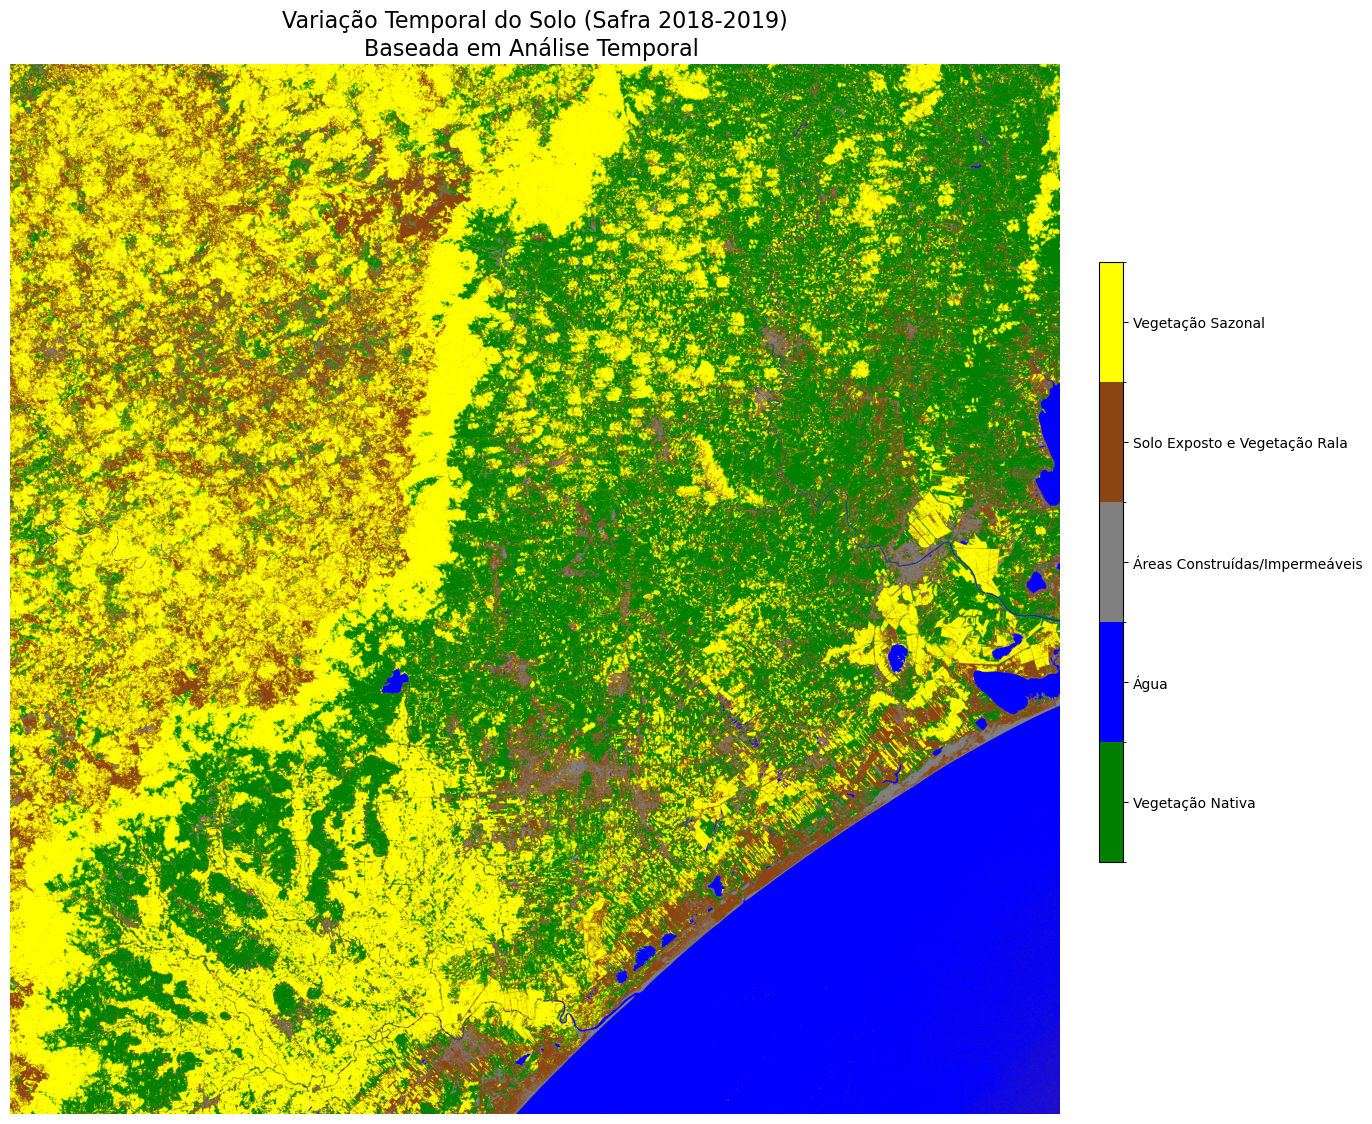

In [54]:


print("Gerando e salvando visualizações do mapa de cobertura do solo...")

# --- DEFINIÇÃO DO DIRETÓRIO PARA SALVAR ---
save_dir = r"C:\Users\clima-lagoa02\Documents\lagoa\Natacha\Light_GBM"
os.makedirs(save_dir, exist_ok=True)

array_final = classified_image.astype('uint8')
caminho_geotiff_saida = os.path.join(save_dir, "classificação_2018_2019_geotiff.tif")
profile_para_salvar = profile_imagem.copy()
profile_para_salvar.update({
    'dtype':array_final.dtype,
    'count':1,
    'nodata':0
        })

print(f"Salvando o GeoTIFF de dados em: {caminho_geotiff_saida}...")
with rasterio.open(caminho_geotiff_saida, 'w', **profile_para_salvar) as dst:
    dst.write(array_final, 1)
print("✔ GeoTIFF de dados salvo com sucesso!")

# --- PLOT E SALVAMENTO DO MAPA DE COBERTURA DO SOLO ---
fig, ax = plt.subplots(figsize=(12, 12))

# Definição de cores e normalização
cmap_class = mcolors.ListedColormap(class_colors)
bounds_class = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm_class = mcolors.BoundaryNorm(bounds_class, cmap_class.N)

im = ax.imshow(classified_image, cmap=cmap_class, norm=norm_class)
ax.set_title('Variação Temporal do Solo (Safra 2018-2019)\nBaseada em Análise Temporal ', fontsize=16)
ax.axis('off')

# Legenda de Cores (Colorbar)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(list(class_labels.values()))
plt.tight_layout(rect=[0, 0, 0.9, 1])
'''
# SALVANDO A IMAGEM DO MAPA//descomente para salvar imagem em PNG
path_mapa_final = os.path.join(save_dir, "variação_temporal_2.png")
fig.savefig(path_mapa_final, dpi=300, bbox_inches='tight')
print(f"✔ Mapa final salvo com sucesso em: {path_mapa_final}")
plt.show()
'''
